In [1]:
# Note this code is not optimized and might be very slow, for convergence purposes 5000 data points are 
# generated. If using ensambling this might be decreased while keeping reasonable performance.

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys, os
sys.path.append('../')
from data_handling import Container,load_data,Normalize,Denormalize
from plot_style.style_prab import load_preset,figsize
from plot_style.style_prab import colors as colors_preset
from train_ensemble import train, NN, Loss
from analysis.scan_model import mean
load_preset(scale=1,font_path='../plot_style/font')

matplotlib preset loaded


In [16]:
#run generate_data

In [75]:
path = './toydata.h5'
inputs = ['x']  
outputs = ['y']

din = len(inputs)
dout = len(outputs)
norm = [[[0],[1]],
        [[0],[1]]]

config = {'path' : path, # Path to data
          'epochs': 200, # training epochs
          'estimators': 20, # networks in ensemble
          'inputs': inputs, # input labels
          'outputs': outputs, # output labels
          'samples': 5000, # number of samples form dataset
          'start_ind': 0, # start ind of samples from dataset 
          'batch_size': 1024, # batch size network
          'ratio': 0.9,
          'loss_fun':  Loss(), # loss function
          'model' : [NN(din+dout,din,hidden=4,layers=2),
                     NN(din,dout,hidden=4,layers=2)], # model
          'dest_path':'', # destination path of model
          'cuda' : False,
          'norm' : norm,
          'lr1' : 0.001,
          'lr2' : 0.001,
          'pre_training' : 100,
         }
ensemble_OD = train(config)



Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 3.73953 
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 3.67468 
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 3.32884 
Estimator: 003 | Epoch: 000 | Batch: 000 | Loss: 3.42386 
Estimator: 004 | Epoch: 000 | Batch: 000 | Loss: 3.36494 
Estimator: 005 | Epoch: 000 | Batch: 000 | Loss: 3.25134 
Estimator: 006 | Epoch: 000 | Batch: 000 | Loss: 3.55270 
Estimator: 007 | Epoch: 000 | Batch: 000 | Loss: 3.49327 
Estimator: 008 | Epoch: 000 | Batch: 000 | Loss: 3.73705 
Estimator: 009 | Epoch: 000 | Batch: 000 | Loss: 3.84914 
Estimator: 010 | Epoch: 000 | Batch: 000 | Loss: 3.45005 
Estimator: 011 | Epoch: 000 | Batch: 000 | Loss: 3.81386 
Estimator: 012 | Epoch: 000 | Batch: 000 | Loss: 3.12621 
Estimator: 013 | Epoch: 000 | Batch: 000 | Loss: 3.09690 
Estimator: 014 | Epoch: 000 | Batch: 000 | Loss: 3.46336 
Estimator: 015 | Epoch: 000 | Batch: 000 | Loss: 3.72059 
Estimator: 016 | Epoch: 000 | Batch: 000 | Loss: 3.19978 
Estimator: 017

Estimator: 002 | Epoch: 007 | Batch: 000 | Loss: 2.78052 
Estimator: 003 | Epoch: 007 | Batch: 000 | Loss: 2.74314 
Estimator: 004 | Epoch: 007 | Batch: 000 | Loss: 3.23014 
Estimator: 005 | Epoch: 007 | Batch: 000 | Loss: 2.75809 
Estimator: 006 | Epoch: 007 | Batch: 000 | Loss: 2.71507 
Estimator: 007 | Epoch: 007 | Batch: 000 | Loss: 3.00125 
Estimator: 008 | Epoch: 007 | Batch: 000 | Loss: 2.97777 
Estimator: 009 | Epoch: 007 | Batch: 000 | Loss: 2.88233 
Estimator: 010 | Epoch: 007 | Batch: 000 | Loss: 2.94089 
Estimator: 011 | Epoch: 007 | Batch: 000 | Loss: 2.91521 
Estimator: 012 | Epoch: 007 | Batch: 000 | Loss: 2.81189 
Estimator: 013 | Epoch: 007 | Batch: 000 | Loss: 2.58057 
Estimator: 014 | Epoch: 007 | Batch: 000 | Loss: 2.77950 
Estimator: 015 | Epoch: 007 | Batch: 000 | Loss: 3.03056 
Estimator: 016 | Epoch: 007 | Batch: 000 | Loss: 2.51989 
Estimator: 017 | Epoch: 007 | Batch: 000 | Loss: 3.17718 
Estimator: 018 | Epoch: 007 | Batch: 000 | Loss: 2.75808 
Estimator: 019

Estimator: 005 | Epoch: 014 | Batch: 000 | Loss: 2.21308 
Estimator: 006 | Epoch: 014 | Batch: 000 | Loss: 2.42489 
Estimator: 007 | Epoch: 014 | Batch: 000 | Loss: 2.17807 
Estimator: 008 | Epoch: 014 | Batch: 000 | Loss: 2.27028 
Estimator: 009 | Epoch: 014 | Batch: 000 | Loss: 2.19564 
Estimator: 010 | Epoch: 014 | Batch: 000 | Loss: 2.23694 
Estimator: 011 | Epoch: 014 | Batch: 000 | Loss: 2.34361 
Estimator: 012 | Epoch: 014 | Batch: 000 | Loss: 2.31707 
Estimator: 013 | Epoch: 014 | Batch: 000 | Loss: 2.07242 
Estimator: 014 | Epoch: 014 | Batch: 000 | Loss: 2.13895 
Estimator: 015 | Epoch: 014 | Batch: 000 | Loss: 2.14467 
Estimator: 016 | Epoch: 014 | Batch: 000 | Loss: 2.03313 
Estimator: 017 | Epoch: 014 | Batch: 000 | Loss: 2.39831 
Estimator: 018 | Epoch: 014 | Batch: 000 | Loss: 2.07485 
Estimator: 019 | Epoch: 014 | Batch: 000 | Loss: 2.09812 
Estimator: 000 | Epoch: 015 | Batch: 000 | Loss: 2.21526 
Estimator: 001 | Epoch: 015 | Batch: 000 | Loss: 2.27962 
Estimator: 002

Estimator: 008 | Epoch: 021 | Batch: 000 | Loss: 1.68750 
Estimator: 009 | Epoch: 021 | Batch: 000 | Loss: 1.56375 
Estimator: 010 | Epoch: 021 | Batch: 000 | Loss: 1.71253 
Estimator: 011 | Epoch: 021 | Batch: 000 | Loss: 1.62791 
Estimator: 012 | Epoch: 021 | Batch: 000 | Loss: 1.70161 
Estimator: 013 | Epoch: 021 | Batch: 000 | Loss: 1.51904 
Estimator: 014 | Epoch: 021 | Batch: 000 | Loss: 1.73731 
Estimator: 015 | Epoch: 021 | Batch: 000 | Loss: 1.72237 
Estimator: 016 | Epoch: 021 | Batch: 000 | Loss: 1.56930 
Estimator: 017 | Epoch: 021 | Batch: 000 | Loss: 1.54614 
Estimator: 018 | Epoch: 021 | Batch: 000 | Loss: 1.56776 
Estimator: 019 | Epoch: 021 | Batch: 000 | Loss: 1.47485 
Estimator: 000 | Epoch: 022 | Batch: 000 | Loss: 1.70079 
Estimator: 001 | Epoch: 022 | Batch: 000 | Loss: 1.65719 
Estimator: 002 | Epoch: 022 | Batch: 000 | Loss: 1.51754 
Estimator: 003 | Epoch: 022 | Batch: 000 | Loss: 1.56147 
Estimator: 004 | Epoch: 022 | Batch: 000 | Loss: 1.70605 
Estimator: 005

Estimator: 012 | Epoch: 028 | Batch: 000 | Loss: 1.25883 
Estimator: 013 | Epoch: 028 | Batch: 000 | Loss: 1.28776 
Estimator: 014 | Epoch: 028 | Batch: 000 | Loss: 1.30119 
Estimator: 015 | Epoch: 028 | Batch: 000 | Loss: 1.45589 
Estimator: 016 | Epoch: 028 | Batch: 000 | Loss: 1.18028 
Estimator: 017 | Epoch: 028 | Batch: 000 | Loss: 1.26676 
Estimator: 018 | Epoch: 028 | Batch: 000 | Loss: 1.38898 
Estimator: 019 | Epoch: 028 | Batch: 000 | Loss: 1.27060 
Estimator: 000 | Epoch: 029 | Batch: 000 | Loss: 1.46891 
Estimator: 001 | Epoch: 029 | Batch: 000 | Loss: 1.30507 
Estimator: 002 | Epoch: 029 | Batch: 000 | Loss: 1.24857 
Estimator: 003 | Epoch: 029 | Batch: 000 | Loss: 1.49164 
Estimator: 004 | Epoch: 029 | Batch: 000 | Loss: 1.16060 
Estimator: 005 | Epoch: 029 | Batch: 000 | Loss: 1.26652 
Estimator: 006 | Epoch: 029 | Batch: 000 | Loss: 1.13619 
Estimator: 007 | Epoch: 029 | Batch: 000 | Loss: 1.17550 
Estimator: 008 | Epoch: 029 | Batch: 000 | Loss: 1.25519 
Estimator: 009

Estimator: 016 | Epoch: 035 | Batch: 000 | Loss: 1.11004 
Estimator: 017 | Epoch: 035 | Batch: 000 | Loss: 1.05855 
Estimator: 018 | Epoch: 035 | Batch: 000 | Loss: 1.01884 
Estimator: 019 | Epoch: 035 | Batch: 000 | Loss: 1.02617 
Estimator: 000 | Epoch: 036 | Batch: 000 | Loss: 1.07341 
Estimator: 001 | Epoch: 036 | Batch: 000 | Loss: 1.01268 
Estimator: 002 | Epoch: 036 | Batch: 000 | Loss: 1.07540 
Estimator: 003 | Epoch: 036 | Batch: 000 | Loss: 1.03332 
Estimator: 004 | Epoch: 036 | Batch: 000 | Loss: 1.01782 
Estimator: 005 | Epoch: 036 | Batch: 000 | Loss: 0.96002 
Estimator: 006 | Epoch: 036 | Batch: 000 | Loss: 1.07541 
Estimator: 007 | Epoch: 036 | Batch: 000 | Loss: 0.99220 
Estimator: 008 | Epoch: 036 | Batch: 000 | Loss: 1.04083 
Estimator: 009 | Epoch: 036 | Batch: 000 | Loss: 1.14248 
Estimator: 010 | Epoch: 036 | Batch: 000 | Loss: 1.21574 
Estimator: 011 | Epoch: 036 | Batch: 000 | Loss: 1.17652 
Estimator: 012 | Epoch: 036 | Batch: 000 | Loss: 1.16664 
Estimator: 013

Estimator: 019 | Epoch: 042 | Batch: 000 | Loss: 1.06184 
Estimator: 000 | Epoch: 043 | Batch: 000 | Loss: 0.91802 
Estimator: 001 | Epoch: 043 | Batch: 000 | Loss: 1.01039 
Estimator: 002 | Epoch: 043 | Batch: 000 | Loss: 0.98912 
Estimator: 003 | Epoch: 043 | Batch: 000 | Loss: 0.85759 
Estimator: 004 | Epoch: 043 | Batch: 000 | Loss: 0.94808 
Estimator: 005 | Epoch: 043 | Batch: 000 | Loss: 0.96649 
Estimator: 006 | Epoch: 043 | Batch: 000 | Loss: 0.90420 
Estimator: 007 | Epoch: 043 | Batch: 000 | Loss: 1.02213 
Estimator: 008 | Epoch: 043 | Batch: 000 | Loss: 1.14203 
Estimator: 009 | Epoch: 043 | Batch: 000 | Loss: 1.02157 
Estimator: 010 | Epoch: 043 | Batch: 000 | Loss: 1.07673 
Estimator: 011 | Epoch: 043 | Batch: 000 | Loss: 1.02667 
Estimator: 012 | Epoch: 043 | Batch: 000 | Loss: 0.96917 
Estimator: 013 | Epoch: 043 | Batch: 000 | Loss: 0.86140 
Estimator: 014 | Epoch: 043 | Batch: 000 | Loss: 0.91159 
Estimator: 015 | Epoch: 043 | Batch: 000 | Loss: 0.90782 
Estimator: 016

Estimator: 003 | Epoch: 050 | Batch: 000 | Loss: 0.83888 
Estimator: 004 | Epoch: 050 | Batch: 000 | Loss: 0.86069 
Estimator: 005 | Epoch: 050 | Batch: 000 | Loss: 0.85529 
Estimator: 006 | Epoch: 050 | Batch: 000 | Loss: 0.78978 
Estimator: 007 | Epoch: 050 | Batch: 000 | Loss: 0.75720 
Estimator: 008 | Epoch: 050 | Batch: 000 | Loss: 0.81654 
Estimator: 009 | Epoch: 050 | Batch: 000 | Loss: 0.78536 
Estimator: 010 | Epoch: 050 | Batch: 000 | Loss: 0.95831 
Estimator: 011 | Epoch: 050 | Batch: 000 | Loss: 0.92554 
Estimator: 012 | Epoch: 050 | Batch: 000 | Loss: 0.93865 
Estimator: 013 | Epoch: 050 | Batch: 000 | Loss: 0.88982 
Estimator: 014 | Epoch: 050 | Batch: 000 | Loss: 0.79821 
Estimator: 015 | Epoch: 050 | Batch: 000 | Loss: 0.88754 
Estimator: 016 | Epoch: 050 | Batch: 000 | Loss: 0.91062 
Estimator: 017 | Epoch: 050 | Batch: 000 | Loss: 0.92136 
Estimator: 018 | Epoch: 050 | Batch: 000 | Loss: 0.83043 
Estimator: 019 | Epoch: 050 | Batch: 000 | Loss: 0.80726 
Estimator: 000

Estimator: 005 | Epoch: 057 | Batch: 000 | Loss: 0.74586 
Estimator: 006 | Epoch: 057 | Batch: 000 | Loss: 0.74351 
Estimator: 007 | Epoch: 057 | Batch: 000 | Loss: 0.91338 
Estimator: 008 | Epoch: 057 | Batch: 000 | Loss: 0.80844 
Estimator: 009 | Epoch: 057 | Batch: 000 | Loss: 0.91478 
Estimator: 010 | Epoch: 057 | Batch: 000 | Loss: 0.77747 
Estimator: 011 | Epoch: 057 | Batch: 000 | Loss: 0.88086 
Estimator: 012 | Epoch: 057 | Batch: 000 | Loss: 0.83289 
Estimator: 013 | Epoch: 057 | Batch: 000 | Loss: 0.79043 
Estimator: 014 | Epoch: 057 | Batch: 000 | Loss: 0.79350 
Estimator: 015 | Epoch: 057 | Batch: 000 | Loss: 0.80599 
Estimator: 016 | Epoch: 057 | Batch: 000 | Loss: 0.76125 
Estimator: 017 | Epoch: 057 | Batch: 000 | Loss: 0.72959 
Estimator: 018 | Epoch: 057 | Batch: 000 | Loss: 0.71637 
Estimator: 019 | Epoch: 057 | Batch: 000 | Loss: 0.68977 
Estimator: 000 | Epoch: 058 | Batch: 000 | Loss: 0.85160 
Estimator: 001 | Epoch: 058 | Batch: 000 | Loss: 0.72315 
Estimator: 002

Estimator: 007 | Epoch: 064 | Batch: 000 | Loss: 0.70408 
Estimator: 008 | Epoch: 064 | Batch: 000 | Loss: 0.71347 
Estimator: 009 | Epoch: 064 | Batch: 000 | Loss: 0.64890 
Estimator: 010 | Epoch: 064 | Batch: 000 | Loss: 0.69729 
Estimator: 011 | Epoch: 064 | Batch: 000 | Loss: 0.70719 
Estimator: 012 | Epoch: 064 | Batch: 000 | Loss: 0.76006 
Estimator: 013 | Epoch: 064 | Batch: 000 | Loss: 0.78805 
Estimator: 014 | Epoch: 064 | Batch: 000 | Loss: 0.61963 
Estimator: 015 | Epoch: 064 | Batch: 000 | Loss: 0.61980 
Estimator: 016 | Epoch: 064 | Batch: 000 | Loss: 0.70022 
Estimator: 017 | Epoch: 064 | Batch: 000 | Loss: 0.78544 
Estimator: 018 | Epoch: 064 | Batch: 000 | Loss: 0.88349 
Estimator: 019 | Epoch: 064 | Batch: 000 | Loss: 0.80541 
Estimator: 000 | Epoch: 065 | Batch: 000 | Loss: 0.73022 
Estimator: 001 | Epoch: 065 | Batch: 000 | Loss: 0.85520 
Estimator: 002 | Epoch: 065 | Batch: 000 | Loss: 0.72012 
Estimator: 003 | Epoch: 065 | Batch: 000 | Loss: 0.79819 
Estimator: 004

Estimator: 011 | Epoch: 071 | Batch: 000 | Loss: 0.79224 
Estimator: 012 | Epoch: 071 | Batch: 000 | Loss: 0.79892 
Estimator: 013 | Epoch: 071 | Batch: 000 | Loss: 0.77797 
Estimator: 014 | Epoch: 071 | Batch: 000 | Loss: 0.64108 
Estimator: 015 | Epoch: 071 | Batch: 000 | Loss: 0.71237 
Estimator: 016 | Epoch: 071 | Batch: 000 | Loss: 0.74604 
Estimator: 017 | Epoch: 071 | Batch: 000 | Loss: 0.65629 
Estimator: 018 | Epoch: 071 | Batch: 000 | Loss: 0.65868 
Estimator: 019 | Epoch: 071 | Batch: 000 | Loss: 0.84490 
Estimator: 000 | Epoch: 072 | Batch: 000 | Loss: 0.69163 
Estimator: 001 | Epoch: 072 | Batch: 000 | Loss: 0.70531 
Estimator: 002 | Epoch: 072 | Batch: 000 | Loss: 0.81295 
Estimator: 003 | Epoch: 072 | Batch: 000 | Loss: 0.65991 
Estimator: 004 | Epoch: 072 | Batch: 000 | Loss: 0.71966 
Estimator: 005 | Epoch: 072 | Batch: 000 | Loss: 0.66905 
Estimator: 006 | Epoch: 072 | Batch: 000 | Loss: 0.66397 
Estimator: 007 | Epoch: 072 | Batch: 000 | Loss: 0.64067 
Estimator: 008

Estimator: 016 | Epoch: 078 | Batch: 000 | Loss: 0.67151 
Estimator: 017 | Epoch: 078 | Batch: 000 | Loss: 0.71232 
Estimator: 018 | Epoch: 078 | Batch: 000 | Loss: 0.72826 
Estimator: 019 | Epoch: 078 | Batch: 000 | Loss: 0.58631 
Estimator: 000 | Epoch: 079 | Batch: 000 | Loss: 0.57252 
Estimator: 001 | Epoch: 079 | Batch: 000 | Loss: 0.71183 
Estimator: 002 | Epoch: 079 | Batch: 000 | Loss: 0.64376 
Estimator: 003 | Epoch: 079 | Batch: 000 | Loss: 0.66896 
Estimator: 004 | Epoch: 079 | Batch: 000 | Loss: 0.64317 
Estimator: 005 | Epoch: 079 | Batch: 000 | Loss: 0.64414 
Estimator: 006 | Epoch: 079 | Batch: 000 | Loss: 0.68053 
Estimator: 007 | Epoch: 079 | Batch: 000 | Loss: 0.75880 
Estimator: 008 | Epoch: 079 | Batch: 000 | Loss: 0.71933 
Estimator: 009 | Epoch: 079 | Batch: 000 | Loss: 0.63250 
Estimator: 010 | Epoch: 079 | Batch: 000 | Loss: 0.77506 
Estimator: 011 | Epoch: 079 | Batch: 000 | Loss: 0.81976 
Estimator: 012 | Epoch: 079 | Batch: 000 | Loss: 0.76098 
Estimator: 013

Estimator: 018 | Epoch: 085 | Batch: 000 | Loss: 0.67366 
Estimator: 019 | Epoch: 085 | Batch: 000 | Loss: 0.64610 
Estimator: 000 | Epoch: 086 | Batch: 000 | Loss: 0.53147 
Estimator: 001 | Epoch: 086 | Batch: 000 | Loss: 0.62587 
Estimator: 002 | Epoch: 086 | Batch: 000 | Loss: 0.65607 
Estimator: 003 | Epoch: 086 | Batch: 000 | Loss: 0.64049 
Estimator: 004 | Epoch: 086 | Batch: 000 | Loss: 0.71639 
Estimator: 005 | Epoch: 086 | Batch: 000 | Loss: 0.67836 
Estimator: 006 | Epoch: 086 | Batch: 000 | Loss: 0.71278 
Estimator: 007 | Epoch: 086 | Batch: 000 | Loss: 0.73906 
Estimator: 008 | Epoch: 086 | Batch: 000 | Loss: 0.70707 
Estimator: 009 | Epoch: 086 | Batch: 000 | Loss: 0.67224 
Estimator: 010 | Epoch: 086 | Batch: 000 | Loss: 0.70498 
Estimator: 011 | Epoch: 086 | Batch: 000 | Loss: 0.65993 
Estimator: 012 | Epoch: 086 | Batch: 000 | Loss: 0.66579 
Estimator: 013 | Epoch: 086 | Batch: 000 | Loss: 0.65622 
Estimator: 014 | Epoch: 086 | Batch: 000 | Loss: 0.66682 
Estimator: 015

Estimator: 000 | Epoch: 093 | Batch: 000 | Loss: 0.68834 
Estimator: 001 | Epoch: 093 | Batch: 000 | Loss: 0.61460 
Estimator: 002 | Epoch: 093 | Batch: 000 | Loss: 0.61439 
Estimator: 003 | Epoch: 093 | Batch: 000 | Loss: 0.63998 
Estimator: 004 | Epoch: 093 | Batch: 000 | Loss: 0.66720 
Estimator: 005 | Epoch: 093 | Batch: 000 | Loss: 0.62293 
Estimator: 006 | Epoch: 093 | Batch: 000 | Loss: 0.76421 
Estimator: 007 | Epoch: 093 | Batch: 000 | Loss: 0.63630 
Estimator: 008 | Epoch: 093 | Batch: 000 | Loss: 0.65431 
Estimator: 009 | Epoch: 093 | Batch: 000 | Loss: 0.67225 
Estimator: 010 | Epoch: 093 | Batch: 000 | Loss: 0.70840 
Estimator: 011 | Epoch: 093 | Batch: 000 | Loss: 0.71000 
Estimator: 012 | Epoch: 093 | Batch: 000 | Loss: 0.61829 
Estimator: 013 | Epoch: 093 | Batch: 000 | Loss: 0.64485 
Estimator: 014 | Epoch: 093 | Batch: 000 | Loss: 0.64061 
Estimator: 015 | Epoch: 093 | Batch: 000 | Loss: 0.59357 
Estimator: 016 | Epoch: 093 | Batch: 000 | Loss: 0.60879 
Estimator: 017

Estimator: 003 | Epoch: 100 | Batch: 000 | Loss: 0.63750 
Estimator: 004 | Epoch: 100 | Batch: 000 | Loss: 0.65475 
Estimator: 005 | Epoch: 100 | Batch: 000 | Loss: 0.61023 
Estimator: 006 | Epoch: 100 | Batch: 000 | Loss: 0.68944 
Estimator: 007 | Epoch: 100 | Batch: 000 | Loss: 0.60503 
Estimator: 008 | Epoch: 100 | Batch: 000 | Loss: 0.69797 
Estimator: 009 | Epoch: 100 | Batch: 000 | Loss: 0.64361 
Estimator: 010 | Epoch: 100 | Batch: 000 | Loss: 0.71131 
Estimator: 011 | Epoch: 100 | Batch: 000 | Loss: 0.62907 
Estimator: 012 | Epoch: 100 | Batch: 000 | Loss: 0.75712 
Estimator: 013 | Epoch: 100 | Batch: 000 | Loss: 0.59882 
Estimator: 014 | Epoch: 100 | Batch: 000 | Loss: 0.65725 
Estimator: 015 | Epoch: 100 | Batch: 000 | Loss: 0.67619 
Estimator: 016 | Epoch: 100 | Batch: 000 | Loss: 0.59571 
Estimator: 017 | Epoch: 100 | Batch: 000 | Loss: 0.62047 
Estimator: 018 | Epoch: 100 | Batch: 000 | Loss: 0.69755 
Estimator: 019 | Epoch: 100 | Batch: 000 | Loss: 0.65165 
Estimator: 000

Estimator: 005 | Epoch: 107 | Batch: 000 | Loss: 0.55275 
Estimator: 006 | Epoch: 107 | Batch: 000 | Loss: 0.54326 
Estimator: 007 | Epoch: 107 | Batch: 000 | Loss: 0.51640 
Estimator: 008 | Epoch: 107 | Batch: 000 | Loss: 0.54184 
Estimator: 009 | Epoch: 107 | Batch: 000 | Loss: 0.53093 
Estimator: 010 | Epoch: 107 | Batch: 000 | Loss: 0.53070 
Estimator: 011 | Epoch: 107 | Batch: 000 | Loss: 0.55201 
Estimator: 012 | Epoch: 107 | Batch: 000 | Loss: 0.60259 
Estimator: 013 | Epoch: 107 | Batch: 000 | Loss: 0.49812 
Estimator: 014 | Epoch: 107 | Batch: 000 | Loss: 0.55429 
Estimator: 015 | Epoch: 107 | Batch: 000 | Loss: 0.57012 
Estimator: 016 | Epoch: 107 | Batch: 000 | Loss: 0.50691 
Estimator: 017 | Epoch: 107 | Batch: 000 | Loss: 0.51508 
Estimator: 018 | Epoch: 107 | Batch: 000 | Loss: 0.55728 
Estimator: 019 | Epoch: 107 | Batch: 000 | Loss: 0.54940 
Estimator: 000 | Epoch: 108 | Batch: 000 | Loss: 0.52922 
Estimator: 001 | Epoch: 108 | Batch: 000 | Loss: 0.48475 
Estimator: 002

Estimator: 008 | Epoch: 114 | Batch: 000 | Loss: 0.51969 
Estimator: 009 | Epoch: 114 | Batch: 000 | Loss: 0.49289 
Estimator: 010 | Epoch: 114 | Batch: 000 | Loss: 0.59493 
Estimator: 011 | Epoch: 114 | Batch: 000 | Loss: 0.49138 
Estimator: 012 | Epoch: 114 | Batch: 000 | Loss: 0.51317 
Estimator: 013 | Epoch: 114 | Batch: 000 | Loss: 0.48490 
Estimator: 014 | Epoch: 114 | Batch: 000 | Loss: 0.51878 
Estimator: 015 | Epoch: 114 | Batch: 000 | Loss: 0.59655 
Estimator: 016 | Epoch: 114 | Batch: 000 | Loss: 0.49307 
Estimator: 017 | Epoch: 114 | Batch: 000 | Loss: 0.48505 
Estimator: 018 | Epoch: 114 | Batch: 000 | Loss: 0.46474 
Estimator: 019 | Epoch: 114 | Batch: 000 | Loss: 0.53023 
Estimator: 000 | Epoch: 115 | Batch: 000 | Loss: 0.52023 
Estimator: 001 | Epoch: 115 | Batch: 000 | Loss: 0.49164 
Estimator: 002 | Epoch: 115 | Batch: 000 | Loss: 0.47840 
Estimator: 003 | Epoch: 115 | Batch: 000 | Loss: 0.51190 
Estimator: 004 | Epoch: 115 | Batch: 000 | Loss: 0.49895 
Estimator: 005

Estimator: 012 | Epoch: 121 | Batch: 000 | Loss: 0.51208 
Estimator: 013 | Epoch: 121 | Batch: 000 | Loss: 0.52898 
Estimator: 014 | Epoch: 121 | Batch: 000 | Loss: 0.51040 
Estimator: 015 | Epoch: 121 | Batch: 000 | Loss: 0.53564 
Estimator: 016 | Epoch: 121 | Batch: 000 | Loss: 0.50049 
Estimator: 017 | Epoch: 121 | Batch: 000 | Loss: 0.48023 
Estimator: 018 | Epoch: 121 | Batch: 000 | Loss: 0.52977 
Estimator: 019 | Epoch: 121 | Batch: 000 | Loss: 0.48714 
Estimator: 000 | Epoch: 122 | Batch: 000 | Loss: 0.47225 
Estimator: 001 | Epoch: 122 | Batch: 000 | Loss: 0.50129 
Estimator: 002 | Epoch: 122 | Batch: 000 | Loss: 0.48410 
Estimator: 003 | Epoch: 122 | Batch: 000 | Loss: 0.51224 
Estimator: 004 | Epoch: 122 | Batch: 000 | Loss: 0.49338 
Estimator: 005 | Epoch: 122 | Batch: 000 | Loss: 0.50225 
Estimator: 006 | Epoch: 122 | Batch: 000 | Loss: 0.49406 
Estimator: 007 | Epoch: 122 | Batch: 000 | Loss: 0.50295 
Estimator: 008 | Epoch: 122 | Batch: 000 | Loss: 0.52076 
Estimator: 009

Estimator: 015 | Epoch: 128 | Batch: 000 | Loss: 0.49783 
Estimator: 016 | Epoch: 128 | Batch: 000 | Loss: 0.48511 
Estimator: 017 | Epoch: 128 | Batch: 000 | Loss: 0.48138 
Estimator: 018 | Epoch: 128 | Batch: 000 | Loss: 0.52121 
Estimator: 019 | Epoch: 128 | Batch: 000 | Loss: 0.50067 
Estimator: 000 | Epoch: 129 | Batch: 000 | Loss: 0.54302 
Estimator: 001 | Epoch: 129 | Batch: 000 | Loss: 0.48473 
Estimator: 002 | Epoch: 129 | Batch: 000 | Loss: 0.48273 
Estimator: 003 | Epoch: 129 | Batch: 000 | Loss: 0.54231 
Estimator: 004 | Epoch: 129 | Batch: 000 | Loss: 0.50539 
Estimator: 005 | Epoch: 129 | Batch: 000 | Loss: 0.57463 
Estimator: 006 | Epoch: 129 | Batch: 000 | Loss: 0.49780 
Estimator: 007 | Epoch: 129 | Batch: 000 | Loss: 0.51073 
Estimator: 008 | Epoch: 129 | Batch: 000 | Loss: 0.55387 
Estimator: 009 | Epoch: 129 | Batch: 000 | Loss: 0.52668 
Estimator: 010 | Epoch: 129 | Batch: 000 | Loss: 0.56202 
Estimator: 011 | Epoch: 129 | Batch: 000 | Loss: 0.53883 
Estimator: 012

Estimator: 018 | Epoch: 135 | Batch: 000 | Loss: 0.52374 
Estimator: 019 | Epoch: 135 | Batch: 000 | Loss: 0.51446 
Estimator: 000 | Epoch: 136 | Batch: 000 | Loss: 0.44569 
Estimator: 001 | Epoch: 136 | Batch: 000 | Loss: 0.49563 
Estimator: 002 | Epoch: 136 | Batch: 000 | Loss: 0.49055 
Estimator: 003 | Epoch: 136 | Batch: 000 | Loss: 0.49329 
Estimator: 004 | Epoch: 136 | Batch: 000 | Loss: 0.49106 
Estimator: 005 | Epoch: 136 | Batch: 000 | Loss: 0.49093 
Estimator: 006 | Epoch: 136 | Batch: 000 | Loss: 0.53991 
Estimator: 007 | Epoch: 136 | Batch: 000 | Loss: 0.50135 
Estimator: 008 | Epoch: 136 | Batch: 000 | Loss: 0.50437 
Estimator: 009 | Epoch: 136 | Batch: 000 | Loss: 0.53541 
Estimator: 010 | Epoch: 136 | Batch: 000 | Loss: 0.56169 
Estimator: 011 | Epoch: 136 | Batch: 000 | Loss: 0.50413 
Estimator: 012 | Epoch: 136 | Batch: 000 | Loss: 0.54310 
Estimator: 013 | Epoch: 136 | Batch: 000 | Loss: 0.49566 
Estimator: 014 | Epoch: 136 | Batch: 000 | Loss: 0.49656 
Estimator: 015

Estimator: 000 | Epoch: 143 | Batch: 000 | Loss: 0.49127 
Estimator: 001 | Epoch: 143 | Batch: 000 | Loss: 0.46928 
Estimator: 002 | Epoch: 143 | Batch: 000 | Loss: 0.51495 
Estimator: 003 | Epoch: 143 | Batch: 000 | Loss: 0.47542 
Estimator: 004 | Epoch: 143 | Batch: 000 | Loss: 0.49815 
Estimator: 005 | Epoch: 143 | Batch: 000 | Loss: 0.52562 
Estimator: 006 | Epoch: 143 | Batch: 000 | Loss: 0.50866 
Estimator: 007 | Epoch: 143 | Batch: 000 | Loss: 0.50837 
Estimator: 008 | Epoch: 143 | Batch: 000 | Loss: 0.51214 
Estimator: 009 | Epoch: 143 | Batch: 000 | Loss: 0.53847 
Estimator: 010 | Epoch: 143 | Batch: 000 | Loss: 0.50348 
Estimator: 011 | Epoch: 143 | Batch: 000 | Loss: 0.48092 
Estimator: 012 | Epoch: 143 | Batch: 000 | Loss: 0.50126 
Estimator: 013 | Epoch: 143 | Batch: 000 | Loss: 0.44234 
Estimator: 014 | Epoch: 143 | Batch: 000 | Loss: 0.50576 
Estimator: 015 | Epoch: 143 | Batch: 000 | Loss: 0.48721 
Estimator: 016 | Epoch: 143 | Batch: 000 | Loss: 0.48738 
Estimator: 017

Estimator: 003 | Epoch: 150 | Batch: 000 | Loss: 0.49965 
Estimator: 004 | Epoch: 150 | Batch: 000 | Loss: 0.51837 
Estimator: 005 | Epoch: 150 | Batch: 000 | Loss: 0.45966 
Estimator: 006 | Epoch: 150 | Batch: 000 | Loss: 0.54304 
Estimator: 007 | Epoch: 150 | Batch: 000 | Loss: 0.52132 
Estimator: 008 | Epoch: 150 | Batch: 000 | Loss: 0.52972 
Estimator: 009 | Epoch: 150 | Batch: 000 | Loss: 0.50259 
Estimator: 010 | Epoch: 150 | Batch: 000 | Loss: 0.52910 
Estimator: 011 | Epoch: 150 | Batch: 000 | Loss: 0.52452 
Estimator: 012 | Epoch: 150 | Batch: 000 | Loss: 0.49091 
Estimator: 013 | Epoch: 150 | Batch: 000 | Loss: 0.49539 
Estimator: 014 | Epoch: 150 | Batch: 000 | Loss: 0.49404 
Estimator: 015 | Epoch: 150 | Batch: 000 | Loss: 0.52822 
Estimator: 016 | Epoch: 150 | Batch: 000 | Loss: 0.50361 
Estimator: 017 | Epoch: 150 | Batch: 000 | Loss: 0.47928 
Estimator: 018 | Epoch: 150 | Batch: 000 | Loss: 0.51202 
Estimator: 019 | Epoch: 150 | Batch: 000 | Loss: 0.47608 
Estimator: 000

Estimator: 005 | Epoch: 157 | Batch: 000 | Loss: 0.49818 
Estimator: 006 | Epoch: 157 | Batch: 000 | Loss: 0.51720 
Estimator: 007 | Epoch: 157 | Batch: 000 | Loss: 0.48474 
Estimator: 008 | Epoch: 157 | Batch: 000 | Loss: 0.51499 
Estimator: 009 | Epoch: 157 | Batch: 000 | Loss: 0.53445 
Estimator: 010 | Epoch: 157 | Batch: 000 | Loss: 0.52537 
Estimator: 011 | Epoch: 157 | Batch: 000 | Loss: 0.52179 
Estimator: 012 | Epoch: 157 | Batch: 000 | Loss: 0.52126 
Estimator: 013 | Epoch: 157 | Batch: 000 | Loss: 0.48823 
Estimator: 014 | Epoch: 157 | Batch: 000 | Loss: 0.50710 
Estimator: 015 | Epoch: 157 | Batch: 000 | Loss: 0.49463 
Estimator: 016 | Epoch: 157 | Batch: 000 | Loss: 0.47631 
Estimator: 017 | Epoch: 157 | Batch: 000 | Loss: 0.48463 
Estimator: 018 | Epoch: 157 | Batch: 000 | Loss: 0.48917 
Estimator: 019 | Epoch: 157 | Batch: 000 | Loss: 0.47193 
Estimator: 000 | Epoch: 158 | Batch: 000 | Loss: 0.46777 
Estimator: 001 | Epoch: 158 | Batch: 000 | Loss: 0.47718 
Estimator: 002

Estimator: 010 | Epoch: 164 | Batch: 000 | Loss: 0.52893 
Estimator: 011 | Epoch: 164 | Batch: 000 | Loss: 0.46990 
Estimator: 012 | Epoch: 164 | Batch: 000 | Loss: 0.48908 
Estimator: 013 | Epoch: 164 | Batch: 000 | Loss: 0.46738 
Estimator: 014 | Epoch: 164 | Batch: 000 | Loss: 0.43975 
Estimator: 015 | Epoch: 164 | Batch: 000 | Loss: 0.50570 
Estimator: 016 | Epoch: 164 | Batch: 000 | Loss: 0.45980 
Estimator: 017 | Epoch: 164 | Batch: 000 | Loss: 0.51621 
Estimator: 018 | Epoch: 164 | Batch: 000 | Loss: 0.49448 
Estimator: 019 | Epoch: 164 | Batch: 000 | Loss: 0.53359 
Estimator: 000 | Epoch: 165 | Batch: 000 | Loss: 0.49960 
Estimator: 001 | Epoch: 165 | Batch: 000 | Loss: 0.49735 
Estimator: 002 | Epoch: 165 | Batch: 000 | Loss: 0.48444 
Estimator: 003 | Epoch: 165 | Batch: 000 | Loss: 0.49256 
Estimator: 004 | Epoch: 165 | Batch: 000 | Loss: 0.45563 
Estimator: 005 | Epoch: 165 | Batch: 000 | Loss: 0.49522 
Estimator: 006 | Epoch: 165 | Batch: 000 | Loss: 0.50383 
Estimator: 007

Estimator: 014 | Epoch: 171 | Batch: 000 | Loss: 0.49721 
Estimator: 015 | Epoch: 171 | Batch: 000 | Loss: 0.56995 
Estimator: 016 | Epoch: 171 | Batch: 000 | Loss: 0.44597 
Estimator: 017 | Epoch: 171 | Batch: 000 | Loss: 0.45242 
Estimator: 018 | Epoch: 171 | Batch: 000 | Loss: 0.45963 
Estimator: 019 | Epoch: 171 | Batch: 000 | Loss: 0.49241 
Estimator: 000 | Epoch: 172 | Batch: 000 | Loss: 0.50127 
Estimator: 001 | Epoch: 172 | Batch: 000 | Loss: 0.47358 
Estimator: 002 | Epoch: 172 | Batch: 000 | Loss: 0.51691 
Estimator: 003 | Epoch: 172 | Batch: 000 | Loss: 0.46652 
Estimator: 004 | Epoch: 172 | Batch: 000 | Loss: 0.46825 
Estimator: 005 | Epoch: 172 | Batch: 000 | Loss: 0.47626 
Estimator: 006 | Epoch: 172 | Batch: 000 | Loss: 0.49350 
Estimator: 007 | Epoch: 172 | Batch: 000 | Loss: 0.50079 
Estimator: 008 | Epoch: 172 | Batch: 000 | Loss: 0.49290 
Estimator: 009 | Epoch: 172 | Batch: 000 | Loss: 0.52955 
Estimator: 010 | Epoch: 172 | Batch: 000 | Loss: 0.55676 
Estimator: 011

Estimator: 017 | Epoch: 178 | Batch: 000 | Loss: 0.47218 
Estimator: 018 | Epoch: 178 | Batch: 000 | Loss: 0.47865 
Estimator: 019 | Epoch: 178 | Batch: 000 | Loss: 0.52705 
Estimator: 000 | Epoch: 179 | Batch: 000 | Loss: 0.49203 
Estimator: 001 | Epoch: 179 | Batch: 000 | Loss: 0.51876 
Estimator: 002 | Epoch: 179 | Batch: 000 | Loss: 0.45696 
Estimator: 003 | Epoch: 179 | Batch: 000 | Loss: 0.46363 
Estimator: 004 | Epoch: 179 | Batch: 000 | Loss: 0.50679 
Estimator: 005 | Epoch: 179 | Batch: 000 | Loss: 0.46675 
Estimator: 006 | Epoch: 179 | Batch: 000 | Loss: 0.50296 
Estimator: 007 | Epoch: 179 | Batch: 000 | Loss: 0.51279 
Estimator: 008 | Epoch: 179 | Batch: 000 | Loss: 0.49099 
Estimator: 009 | Epoch: 179 | Batch: 000 | Loss: 0.47528 
Estimator: 010 | Epoch: 179 | Batch: 000 | Loss: 0.48993 
Estimator: 011 | Epoch: 179 | Batch: 000 | Loss: 0.50455 
Estimator: 012 | Epoch: 179 | Batch: 000 | Loss: 0.49795 
Estimator: 013 | Epoch: 179 | Batch: 000 | Loss: 0.46726 
Estimator: 014

Estimator: 000 | Epoch: 186 | Batch: 000 | Loss: 0.45583 
Estimator: 001 | Epoch: 186 | Batch: 000 | Loss: 0.47985 
Estimator: 002 | Epoch: 186 | Batch: 000 | Loss: 0.49461 
Estimator: 003 | Epoch: 186 | Batch: 000 | Loss: 0.52674 
Estimator: 004 | Epoch: 186 | Batch: 000 | Loss: 0.45448 
Estimator: 005 | Epoch: 186 | Batch: 000 | Loss: 0.52541 
Estimator: 006 | Epoch: 186 | Batch: 000 | Loss: 0.52426 
Estimator: 007 | Epoch: 186 | Batch: 000 | Loss: 0.48614 
Estimator: 008 | Epoch: 186 | Batch: 000 | Loss: 0.50437 
Estimator: 009 | Epoch: 186 | Batch: 000 | Loss: 0.48668 
Estimator: 010 | Epoch: 186 | Batch: 000 | Loss: 0.51464 
Estimator: 011 | Epoch: 186 | Batch: 000 | Loss: 0.48832 
Estimator: 012 | Epoch: 186 | Batch: 000 | Loss: 0.51018 
Estimator: 013 | Epoch: 186 | Batch: 000 | Loss: 0.48269 
Estimator: 014 | Epoch: 186 | Batch: 000 | Loss: 0.48694 
Estimator: 015 | Epoch: 186 | Batch: 000 | Loss: 0.52602 
Estimator: 016 | Epoch: 186 | Batch: 000 | Loss: 0.47267 
Estimator: 017

Estimator: 005 | Epoch: 193 | Batch: 000 | Loss: 0.47440 
Estimator: 006 | Epoch: 193 | Batch: 000 | Loss: 0.49625 
Estimator: 007 | Epoch: 193 | Batch: 000 | Loss: 0.50284 
Estimator: 008 | Epoch: 193 | Batch: 000 | Loss: 0.51584 
Estimator: 009 | Epoch: 193 | Batch: 000 | Loss: 0.49963 
Estimator: 010 | Epoch: 193 | Batch: 000 | Loss: 0.49891 
Estimator: 011 | Epoch: 193 | Batch: 000 | Loss: 0.48674 
Estimator: 012 | Epoch: 193 | Batch: 000 | Loss: 0.53809 
Estimator: 013 | Epoch: 193 | Batch: 000 | Loss: 0.44327 
Estimator: 014 | Epoch: 193 | Batch: 000 | Loss: 0.46100 
Estimator: 015 | Epoch: 193 | Batch: 000 | Loss: 0.49187 
Estimator: 016 | Epoch: 193 | Batch: 000 | Loss: 0.51167 
Estimator: 017 | Epoch: 193 | Batch: 000 | Loss: 0.45526 
Estimator: 018 | Epoch: 193 | Batch: 000 | Loss: 0.52551 
Estimator: 019 | Epoch: 193 | Batch: 000 | Loss: 0.50025 
Estimator: 000 | Epoch: 194 | Batch: 000 | Loss: 0.45816 
Estimator: 001 | Epoch: 194 | Batch: 000 | Loss: 0.46536 
Estimator: 002

In [76]:
path = './toydata.h5'
inputs = ['x']  
outputs = ['y']

din = len(inputs)
dout = len(outputs)
norm = [[[0],[1]],
        [[0],[1]]]

config = {'path' : path, # Path to data
          'epochs': 200, # training epochs
          'estimators': 20, # networks in ensemble
          'inputs': inputs, # input labels
          'outputs': outputs, # output labels
          'samples': 5000, # number of samples form dataset
          'start_ind': 0, # start ind of samples from dataset 
          'batch_size': 1024, # batch size network
          'ratio': 0.9,
          'loss_fun':  Loss(), # loss function
          'model' : [NN(din+dout,din,hidden=4,layers=2),
                     NN(din,dout,hidden=4,layers=2)], # model
          'dest_path':'', # destination path of model
          'cuda' : False,
          'norm' : norm,
          'lr1' : 0.001,
          'lr2' : 0.001,
          'pre_training' : 200, # all epochs are with MSE loss 
         }

ensemble_MSE = train(config)

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 6.09396 
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 5.86116 
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 5.43907 
Estimator: 003 | Epoch: 000 | Batch: 000 | Loss: 5.19576 
Estimator: 004 | Epoch: 000 | Batch: 000 | Loss: 6.08590 
Estimator: 005 | Epoch: 000 | Batch: 000 | Loss: 5.51524 
Estimator: 006 | Epoch: 000 | Batch: 000 | Loss: 5.92130 
Estimator: 007 | Epoch: 000 | Batch: 000 | Loss: 5.85739 
Estimator: 008 | Epoch: 000 | Batch: 000 | Loss: 6.00661 
Estimator: 009 | Epoch: 000 | Batch: 000 | Loss: 5.26228 
Estimator: 010 | Epoch: 000 | Batch: 000 | Loss: 5.78325 
Estimator: 011 | Epoch: 000 | Batch: 000 | Loss: 5.56801 
Estimator: 012 | Epoch: 000 | Batch: 000 | Loss: 6.26229 
Estimator: 013 | Epoch: 000 | Batch: 000 | Loss: 6.24477 
Estimator: 014 | Epoch: 000 | Batch: 000 | Loss: 5.77145 
Estimator: 015 | Epoch: 000 | Batch: 000 | Loss: 5.72302 
Estimator: 016 | Epoch: 000 | Batch: 000 | Loss: 6.35757 
Estimator: 017

Estimator: 005 | Epoch: 007 | Batch: 000 | Loss: 4.57301 
Estimator: 006 | Epoch: 007 | Batch: 000 | Loss: 4.57896 
Estimator: 007 | Epoch: 007 | Batch: 000 | Loss: 4.43965 
Estimator: 008 | Epoch: 007 | Batch: 000 | Loss: 4.45110 
Estimator: 009 | Epoch: 007 | Batch: 000 | Loss: 4.32406 
Estimator: 010 | Epoch: 007 | Batch: 000 | Loss: 4.35394 
Estimator: 011 | Epoch: 007 | Batch: 000 | Loss: 4.35404 
Estimator: 012 | Epoch: 007 | Batch: 000 | Loss: 4.61178 
Estimator: 013 | Epoch: 007 | Batch: 000 | Loss: 4.84912 
Estimator: 014 | Epoch: 007 | Batch: 000 | Loss: 4.59741 
Estimator: 015 | Epoch: 007 | Batch: 000 | Loss: 4.46851 
Estimator: 016 | Epoch: 007 | Batch: 000 | Loss: 5.06358 
Estimator: 017 | Epoch: 007 | Batch: 000 | Loss: 4.42798 
Estimator: 018 | Epoch: 007 | Batch: 000 | Loss: 4.67907 
Estimator: 019 | Epoch: 007 | Batch: 000 | Loss: 4.34830 
Estimator: 000 | Epoch: 008 | Batch: 000 | Loss: 4.32544 
Estimator: 001 | Epoch: 008 | Batch: 000 | Loss: 4.17013 
Estimator: 002

Estimator: 008 | Epoch: 014 | Batch: 000 | Loss: 3.17049 
Estimator: 009 | Epoch: 014 | Batch: 000 | Loss: 3.04254 
Estimator: 010 | Epoch: 014 | Batch: 000 | Loss: 3.32951 
Estimator: 011 | Epoch: 014 | Batch: 000 | Loss: 3.32858 
Estimator: 012 | Epoch: 014 | Batch: 000 | Loss: 3.39983 
Estimator: 013 | Epoch: 014 | Batch: 000 | Loss: 3.36662 
Estimator: 014 | Epoch: 014 | Batch: 000 | Loss: 3.54177 
Estimator: 015 | Epoch: 014 | Batch: 000 | Loss: 3.35900 
Estimator: 016 | Epoch: 014 | Batch: 000 | Loss: 3.54689 
Estimator: 017 | Epoch: 014 | Batch: 000 | Loss: 3.70866 
Estimator: 018 | Epoch: 014 | Batch: 000 | Loss: 3.17008 
Estimator: 019 | Epoch: 014 | Batch: 000 | Loss: 3.38453 
Estimator: 000 | Epoch: 015 | Batch: 000 | Loss: 3.14557 
Estimator: 001 | Epoch: 015 | Batch: 000 | Loss: 3.48194 
Estimator: 002 | Epoch: 015 | Batch: 000 | Loss: 3.64640 
Estimator: 003 | Epoch: 015 | Batch: 000 | Loss: 3.37296 
Estimator: 004 | Epoch: 015 | Batch: 000 | Loss: 2.97980 
Estimator: 005

Estimator: 010 | Epoch: 021 | Batch: 000 | Loss: 2.41114 
Estimator: 011 | Epoch: 021 | Batch: 000 | Loss: 2.39111 
Estimator: 012 | Epoch: 021 | Batch: 000 | Loss: 2.31354 
Estimator: 013 | Epoch: 021 | Batch: 000 | Loss: 2.89327 
Estimator: 014 | Epoch: 021 | Batch: 000 | Loss: 2.45601 
Estimator: 015 | Epoch: 021 | Batch: 000 | Loss: 2.71937 
Estimator: 016 | Epoch: 021 | Batch: 000 | Loss: 2.43328 
Estimator: 017 | Epoch: 021 | Batch: 000 | Loss: 2.47775 
Estimator: 018 | Epoch: 021 | Batch: 000 | Loss: 2.43403 
Estimator: 019 | Epoch: 021 | Batch: 000 | Loss: 2.38343 
Estimator: 000 | Epoch: 022 | Batch: 000 | Loss: 2.30634 
Estimator: 001 | Epoch: 022 | Batch: 000 | Loss: 2.40428 
Estimator: 002 | Epoch: 022 | Batch: 000 | Loss: 2.08808 
Estimator: 003 | Epoch: 022 | Batch: 000 | Loss: 2.24587 
Estimator: 004 | Epoch: 022 | Batch: 000 | Loss: 2.16012 
Estimator: 005 | Epoch: 022 | Batch: 000 | Loss: 2.26895 
Estimator: 006 | Epoch: 022 | Batch: 000 | Loss: 2.09641 
Estimator: 007

Estimator: 012 | Epoch: 028 | Batch: 000 | Loss: 1.68523 
Estimator: 013 | Epoch: 028 | Batch: 000 | Loss: 1.59361 
Estimator: 014 | Epoch: 028 | Batch: 000 | Loss: 1.56792 
Estimator: 015 | Epoch: 028 | Batch: 000 | Loss: 1.58664 
Estimator: 016 | Epoch: 028 | Batch: 000 | Loss: 1.63513 
Estimator: 017 | Epoch: 028 | Batch: 000 | Loss: 1.67542 
Estimator: 018 | Epoch: 028 | Batch: 000 | Loss: 1.56250 
Estimator: 019 | Epoch: 028 | Batch: 000 | Loss: 1.79895 
Estimator: 000 | Epoch: 029 | Batch: 000 | Loss: 1.50499 
Estimator: 001 | Epoch: 029 | Batch: 000 | Loss: 1.70801 
Estimator: 002 | Epoch: 029 | Batch: 000 | Loss: 1.66420 
Estimator: 003 | Epoch: 029 | Batch: 000 | Loss: 1.38684 
Estimator: 004 | Epoch: 029 | Batch: 000 | Loss: 1.25381 
Estimator: 005 | Epoch: 029 | Batch: 000 | Loss: 1.35110 
Estimator: 006 | Epoch: 029 | Batch: 000 | Loss: 1.61264 
Estimator: 007 | Epoch: 029 | Batch: 000 | Loss: 1.49067 
Estimator: 008 | Epoch: 029 | Batch: 000 | Loss: 1.54606 
Estimator: 009

Estimator: 016 | Epoch: 035 | Batch: 000 | Loss: 1.44607 
Estimator: 017 | Epoch: 035 | Batch: 000 | Loss: 1.30523 
Estimator: 018 | Epoch: 035 | Batch: 000 | Loss: 1.35099 
Estimator: 019 | Epoch: 035 | Batch: 000 | Loss: 1.20413 
Estimator: 000 | Epoch: 036 | Batch: 000 | Loss: 1.30426 
Estimator: 001 | Epoch: 036 | Batch: 000 | Loss: 1.32546 
Estimator: 002 | Epoch: 036 | Batch: 000 | Loss: 1.19521 
Estimator: 003 | Epoch: 036 | Batch: 000 | Loss: 1.03983 
Estimator: 004 | Epoch: 036 | Batch: 000 | Loss: 1.26883 
Estimator: 005 | Epoch: 036 | Batch: 000 | Loss: 1.17743 
Estimator: 006 | Epoch: 036 | Batch: 000 | Loss: 1.08359 
Estimator: 007 | Epoch: 036 | Batch: 000 | Loss: 1.28540 
Estimator: 008 | Epoch: 036 | Batch: 000 | Loss: 1.27197 
Estimator: 009 | Epoch: 036 | Batch: 000 | Loss: 1.16712 
Estimator: 010 | Epoch: 036 | Batch: 000 | Loss: 1.27869 
Estimator: 011 | Epoch: 036 | Batch: 000 | Loss: 1.45866 
Estimator: 012 | Epoch: 036 | Batch: 000 | Loss: 1.16884 
Estimator: 013

Estimator: 018 | Epoch: 042 | Batch: 000 | Loss: 0.98314 
Estimator: 019 | Epoch: 042 | Batch: 000 | Loss: 1.02970 
Estimator: 000 | Epoch: 043 | Batch: 000 | Loss: 0.86368 
Estimator: 001 | Epoch: 043 | Batch: 000 | Loss: 0.93141 
Estimator: 002 | Epoch: 043 | Batch: 000 | Loss: 1.02764 
Estimator: 003 | Epoch: 043 | Batch: 000 | Loss: 0.99582 
Estimator: 004 | Epoch: 043 | Batch: 000 | Loss: 0.87853 
Estimator: 005 | Epoch: 043 | Batch: 000 | Loss: 0.86856 
Estimator: 006 | Epoch: 043 | Batch: 000 | Loss: 0.95819 
Estimator: 007 | Epoch: 043 | Batch: 000 | Loss: 0.96264 
Estimator: 008 | Epoch: 043 | Batch: 000 | Loss: 1.01322 
Estimator: 009 | Epoch: 043 | Batch: 000 | Loss: 1.06069 
Estimator: 010 | Epoch: 043 | Batch: 000 | Loss: 1.03490 
Estimator: 011 | Epoch: 043 | Batch: 000 | Loss: 0.87212 
Estimator: 012 | Epoch: 043 | Batch: 000 | Loss: 0.96321 
Estimator: 013 | Epoch: 043 | Batch: 000 | Loss: 0.99252 
Estimator: 014 | Epoch: 043 | Batch: 000 | Loss: 1.01010 
Estimator: 015

Estimator: 000 | Epoch: 050 | Batch: 000 | Loss: 0.78847 
Estimator: 001 | Epoch: 050 | Batch: 000 | Loss: 0.75968 
Estimator: 002 | Epoch: 050 | Batch: 000 | Loss: 0.85583 
Estimator: 003 | Epoch: 050 | Batch: 000 | Loss: 0.86267 
Estimator: 004 | Epoch: 050 | Batch: 000 | Loss: 0.84707 
Estimator: 005 | Epoch: 050 | Batch: 000 | Loss: 0.77424 
Estimator: 006 | Epoch: 050 | Batch: 000 | Loss: 0.97992 
Estimator: 007 | Epoch: 050 | Batch: 000 | Loss: 0.77390 
Estimator: 008 | Epoch: 050 | Batch: 000 | Loss: 0.83345 
Estimator: 009 | Epoch: 050 | Batch: 000 | Loss: 0.81376 
Estimator: 010 | Epoch: 050 | Batch: 000 | Loss: 0.81444 
Estimator: 011 | Epoch: 050 | Batch: 000 | Loss: 0.76717 
Estimator: 012 | Epoch: 050 | Batch: 000 | Loss: 0.80603 
Estimator: 013 | Epoch: 050 | Batch: 000 | Loss: 0.77957 
Estimator: 014 | Epoch: 050 | Batch: 000 | Loss: 0.68232 
Estimator: 015 | Epoch: 050 | Batch: 000 | Loss: 0.92176 
Estimator: 016 | Epoch: 050 | Batch: 000 | Loss: 0.77834 
Estimator: 017

Estimator: 002 | Epoch: 057 | Batch: 000 | Loss: 0.70253 
Estimator: 003 | Epoch: 057 | Batch: 000 | Loss: 0.68975 
Estimator: 004 | Epoch: 057 | Batch: 000 | Loss: 0.69667 
Estimator: 005 | Epoch: 057 | Batch: 000 | Loss: 0.71846 
Estimator: 006 | Epoch: 057 | Batch: 000 | Loss: 0.77444 
Estimator: 007 | Epoch: 057 | Batch: 000 | Loss: 0.78201 
Estimator: 008 | Epoch: 057 | Batch: 000 | Loss: 0.73877 
Estimator: 009 | Epoch: 057 | Batch: 000 | Loss: 0.69996 
Estimator: 010 | Epoch: 057 | Batch: 000 | Loss: 0.76885 
Estimator: 011 | Epoch: 057 | Batch: 000 | Loss: 0.70229 
Estimator: 012 | Epoch: 057 | Batch: 000 | Loss: 0.63494 
Estimator: 013 | Epoch: 057 | Batch: 000 | Loss: 0.80078 
Estimator: 014 | Epoch: 057 | Batch: 000 | Loss: 0.73579 
Estimator: 015 | Epoch: 057 | Batch: 000 | Loss: 0.79839 
Estimator: 016 | Epoch: 057 | Batch: 000 | Loss: 0.81443 
Estimator: 017 | Epoch: 057 | Batch: 000 | Loss: 0.63174 
Estimator: 018 | Epoch: 057 | Batch: 000 | Loss: 0.79136 
Estimator: 019

Estimator: 004 | Epoch: 064 | Batch: 000 | Loss: 0.71191 
Estimator: 005 | Epoch: 064 | Batch: 000 | Loss: 0.68814 
Estimator: 006 | Epoch: 064 | Batch: 000 | Loss: 0.71294 
Estimator: 007 | Epoch: 064 | Batch: 000 | Loss: 0.67680 
Estimator: 008 | Epoch: 064 | Batch: 000 | Loss: 0.69388 
Estimator: 009 | Epoch: 064 | Batch: 000 | Loss: 0.69823 
Estimator: 010 | Epoch: 064 | Batch: 000 | Loss: 0.72673 
Estimator: 011 | Epoch: 064 | Batch: 000 | Loss: 0.66720 
Estimator: 012 | Epoch: 064 | Batch: 000 | Loss: 0.68906 
Estimator: 013 | Epoch: 064 | Batch: 000 | Loss: 0.73117 
Estimator: 014 | Epoch: 064 | Batch: 000 | Loss: 0.68067 
Estimator: 015 | Epoch: 064 | Batch: 000 | Loss: 0.70275 
Estimator: 016 | Epoch: 064 | Batch: 000 | Loss: 0.67013 
Estimator: 017 | Epoch: 064 | Batch: 000 | Loss: 0.60455 
Estimator: 018 | Epoch: 064 | Batch: 000 | Loss: 0.73264 
Estimator: 019 | Epoch: 064 | Batch: 000 | Loss: 0.64169 
Estimator: 000 | Epoch: 065 | Batch: 000 | Loss: 0.65864 
Estimator: 001

Estimator: 008 | Epoch: 071 | Batch: 000 | Loss: 0.72893 
Estimator: 009 | Epoch: 071 | Batch: 000 | Loss: 0.69324 
Estimator: 010 | Epoch: 071 | Batch: 000 | Loss: 0.73821 
Estimator: 011 | Epoch: 071 | Batch: 000 | Loss: 0.75163 
Estimator: 012 | Epoch: 071 | Batch: 000 | Loss: 0.65749 
Estimator: 013 | Epoch: 071 | Batch: 000 | Loss: 0.69381 
Estimator: 014 | Epoch: 071 | Batch: 000 | Loss: 0.68223 
Estimator: 015 | Epoch: 071 | Batch: 000 | Loss: 0.62269 
Estimator: 016 | Epoch: 071 | Batch: 000 | Loss: 0.67613 
Estimator: 017 | Epoch: 071 | Batch: 000 | Loss: 0.69618 
Estimator: 018 | Epoch: 071 | Batch: 000 | Loss: 0.72202 
Estimator: 019 | Epoch: 071 | Batch: 000 | Loss: 0.70903 
Estimator: 000 | Epoch: 072 | Batch: 000 | Loss: 0.78424 
Estimator: 001 | Epoch: 072 | Batch: 000 | Loss: 0.70890 
Estimator: 002 | Epoch: 072 | Batch: 000 | Loss: 0.72083 
Estimator: 003 | Epoch: 072 | Batch: 000 | Loss: 0.66519 
Estimator: 004 | Epoch: 072 | Batch: 000 | Loss: 0.72261 
Estimator: 005

Estimator: 010 | Epoch: 078 | Batch: 000 | Loss: 0.69614 
Estimator: 011 | Epoch: 078 | Batch: 000 | Loss: 0.60491 
Estimator: 012 | Epoch: 078 | Batch: 000 | Loss: 0.60540 
Estimator: 013 | Epoch: 078 | Batch: 000 | Loss: 0.63009 
Estimator: 014 | Epoch: 078 | Batch: 000 | Loss: 0.69427 
Estimator: 015 | Epoch: 078 | Batch: 000 | Loss: 0.75226 
Estimator: 016 | Epoch: 078 | Batch: 000 | Loss: 0.71907 
Estimator: 017 | Epoch: 078 | Batch: 000 | Loss: 0.69806 
Estimator: 018 | Epoch: 078 | Batch: 000 | Loss: 0.76560 
Estimator: 019 | Epoch: 078 | Batch: 000 | Loss: 0.67532 
Estimator: 000 | Epoch: 079 | Batch: 000 | Loss: 0.66113 
Estimator: 001 | Epoch: 079 | Batch: 000 | Loss: 0.66931 
Estimator: 002 | Epoch: 079 | Batch: 000 | Loss: 0.61255 
Estimator: 003 | Epoch: 079 | Batch: 000 | Loss: 0.58662 
Estimator: 004 | Epoch: 079 | Batch: 000 | Loss: 0.75230 
Estimator: 005 | Epoch: 079 | Batch: 000 | Loss: 0.64701 
Estimator: 006 | Epoch: 079 | Batch: 000 | Loss: 0.70396 
Estimator: 007

Estimator: 013 | Epoch: 085 | Batch: 000 | Loss: 0.77289 
Estimator: 014 | Epoch: 085 | Batch: 000 | Loss: 0.62722 
Estimator: 015 | Epoch: 085 | Batch: 000 | Loss: 0.65156 
Estimator: 016 | Epoch: 085 | Batch: 000 | Loss: 0.78029 
Estimator: 017 | Epoch: 085 | Batch: 000 | Loss: 0.67067 
Estimator: 018 | Epoch: 085 | Batch: 000 | Loss: 0.66671 
Estimator: 019 | Epoch: 085 | Batch: 000 | Loss: 0.55213 
Estimator: 000 | Epoch: 086 | Batch: 000 | Loss: 0.71675 
Estimator: 001 | Epoch: 086 | Batch: 000 | Loss: 0.65479 
Estimator: 002 | Epoch: 086 | Batch: 000 | Loss: 0.77155 
Estimator: 003 | Epoch: 086 | Batch: 000 | Loss: 0.75038 
Estimator: 004 | Epoch: 086 | Batch: 000 | Loss: 0.68514 
Estimator: 005 | Epoch: 086 | Batch: 000 | Loss: 0.70071 
Estimator: 006 | Epoch: 086 | Batch: 000 | Loss: 0.62810 
Estimator: 007 | Epoch: 086 | Batch: 000 | Loss: 0.82366 
Estimator: 008 | Epoch: 086 | Batch: 000 | Loss: 0.62589 
Estimator: 009 | Epoch: 086 | Batch: 000 | Loss: 0.68292 
Estimator: 010

Estimator: 017 | Epoch: 092 | Batch: 000 | Loss: 0.58796 
Estimator: 018 | Epoch: 092 | Batch: 000 | Loss: 0.63580 
Estimator: 019 | Epoch: 092 | Batch: 000 | Loss: 0.56061 
Estimator: 000 | Epoch: 093 | Batch: 000 | Loss: 0.61595 
Estimator: 001 | Epoch: 093 | Batch: 000 | Loss: 0.65755 
Estimator: 002 | Epoch: 093 | Batch: 000 | Loss: 0.68342 
Estimator: 003 | Epoch: 093 | Batch: 000 | Loss: 0.74532 
Estimator: 004 | Epoch: 093 | Batch: 000 | Loss: 0.68755 
Estimator: 005 | Epoch: 093 | Batch: 000 | Loss: 0.65136 
Estimator: 006 | Epoch: 093 | Batch: 000 | Loss: 0.77398 
Estimator: 007 | Epoch: 093 | Batch: 000 | Loss: 0.66625 
Estimator: 008 | Epoch: 093 | Batch: 000 | Loss: 0.67162 
Estimator: 009 | Epoch: 093 | Batch: 000 | Loss: 0.62320 
Estimator: 010 | Epoch: 093 | Batch: 000 | Loss: 0.70411 
Estimator: 011 | Epoch: 093 | Batch: 000 | Loss: 0.69747 
Estimator: 012 | Epoch: 093 | Batch: 000 | Loss: 0.58903 
Estimator: 013 | Epoch: 093 | Batch: 000 | Loss: 0.59253 
Estimator: 014

Estimator: 000 | Epoch: 100 | Batch: 000 | Loss: 0.73814 
Estimator: 001 | Epoch: 100 | Batch: 000 | Loss: 0.56701 
Estimator: 002 | Epoch: 100 | Batch: 000 | Loss: 0.75420 
Estimator: 003 | Epoch: 100 | Batch: 000 | Loss: 0.62851 
Estimator: 004 | Epoch: 100 | Batch: 000 | Loss: 0.63073 
Estimator: 005 | Epoch: 100 | Batch: 000 | Loss: 0.67588 
Estimator: 006 | Epoch: 100 | Batch: 000 | Loss: 0.72075 
Estimator: 007 | Epoch: 100 | Batch: 000 | Loss: 0.65543 
Estimator: 008 | Epoch: 100 | Batch: 000 | Loss: 0.67892 
Estimator: 009 | Epoch: 100 | Batch: 000 | Loss: 0.68318 
Estimator: 010 | Epoch: 100 | Batch: 000 | Loss: 0.63354 
Estimator: 011 | Epoch: 100 | Batch: 000 | Loss: 0.62449 
Estimator: 012 | Epoch: 100 | Batch: 000 | Loss: 0.58848 
Estimator: 013 | Epoch: 100 | Batch: 000 | Loss: 0.65998 
Estimator: 014 | Epoch: 100 | Batch: 000 | Loss: 0.68888 
Estimator: 015 | Epoch: 100 | Batch: 000 | Loss: 0.66658 
Estimator: 016 | Epoch: 100 | Batch: 000 | Loss: 0.66724 
Estimator: 017

Estimator: 005 | Epoch: 107 | Batch: 000 | Loss: 0.64534 
Estimator: 006 | Epoch: 107 | Batch: 000 | Loss: 0.72484 
Estimator: 007 | Epoch: 107 | Batch: 000 | Loss: 0.68247 
Estimator: 008 | Epoch: 107 | Batch: 000 | Loss: 0.64099 
Estimator: 009 | Epoch: 107 | Batch: 000 | Loss: 0.66812 
Estimator: 010 | Epoch: 107 | Batch: 000 | Loss: 0.65231 
Estimator: 011 | Epoch: 107 | Batch: 000 | Loss: 0.67983 
Estimator: 012 | Epoch: 107 | Batch: 000 | Loss: 0.66618 
Estimator: 013 | Epoch: 107 | Batch: 000 | Loss: 0.63627 
Estimator: 014 | Epoch: 107 | Batch: 000 | Loss: 0.72909 
Estimator: 015 | Epoch: 107 | Batch: 000 | Loss: 0.70253 
Estimator: 016 | Epoch: 107 | Batch: 000 | Loss: 0.65555 
Estimator: 017 | Epoch: 107 | Batch: 000 | Loss: 0.60425 
Estimator: 018 | Epoch: 107 | Batch: 000 | Loss: 0.65602 
Estimator: 019 | Epoch: 107 | Batch: 000 | Loss: 0.66702 
Estimator: 000 | Epoch: 108 | Batch: 000 | Loss: 0.62002 
Estimator: 001 | Epoch: 108 | Batch: 000 | Loss: 0.64617 
Estimator: 002

Estimator: 008 | Epoch: 114 | Batch: 000 | Loss: 0.66600 
Estimator: 009 | Epoch: 114 | Batch: 000 | Loss: 0.67416 
Estimator: 010 | Epoch: 114 | Batch: 000 | Loss: 0.65060 
Estimator: 011 | Epoch: 114 | Batch: 000 | Loss: 0.70026 
Estimator: 012 | Epoch: 114 | Batch: 000 | Loss: 0.69647 
Estimator: 013 | Epoch: 114 | Batch: 000 | Loss: 0.67853 
Estimator: 014 | Epoch: 114 | Batch: 000 | Loss: 0.64810 
Estimator: 015 | Epoch: 114 | Batch: 000 | Loss: 0.61605 
Estimator: 016 | Epoch: 114 | Batch: 000 | Loss: 0.65784 
Estimator: 017 | Epoch: 114 | Batch: 000 | Loss: 0.70676 
Estimator: 018 | Epoch: 114 | Batch: 000 | Loss: 0.66129 
Estimator: 019 | Epoch: 114 | Batch: 000 | Loss: 0.69192 
Estimator: 000 | Epoch: 115 | Batch: 000 | Loss: 0.65774 
Estimator: 001 | Epoch: 115 | Batch: 000 | Loss: 0.64348 
Estimator: 002 | Epoch: 115 | Batch: 000 | Loss: 0.61225 
Estimator: 003 | Epoch: 115 | Batch: 000 | Loss: 0.67925 
Estimator: 004 | Epoch: 115 | Batch: 000 | Loss: 0.61073 
Estimator: 005

Estimator: 011 | Epoch: 121 | Batch: 000 | Loss: 0.67276 
Estimator: 012 | Epoch: 121 | Batch: 000 | Loss: 0.63600 
Estimator: 013 | Epoch: 121 | Batch: 000 | Loss: 0.62501 
Estimator: 014 | Epoch: 121 | Batch: 000 | Loss: 0.79453 
Estimator: 015 | Epoch: 121 | Batch: 000 | Loss: 0.59161 
Estimator: 016 | Epoch: 121 | Batch: 000 | Loss: 0.64563 
Estimator: 017 | Epoch: 121 | Batch: 000 | Loss: 0.68040 
Estimator: 018 | Epoch: 121 | Batch: 000 | Loss: 0.63123 
Estimator: 019 | Epoch: 121 | Batch: 000 | Loss: 0.64477 
Estimator: 000 | Epoch: 122 | Batch: 000 | Loss: 0.70680 
Estimator: 001 | Epoch: 122 | Batch: 000 | Loss: 0.65167 
Estimator: 002 | Epoch: 122 | Batch: 000 | Loss: 0.70170 
Estimator: 003 | Epoch: 122 | Batch: 000 | Loss: 0.57692 
Estimator: 004 | Epoch: 122 | Batch: 000 | Loss: 0.67578 
Estimator: 005 | Epoch: 122 | Batch: 000 | Loss: 0.77578 
Estimator: 006 | Epoch: 122 | Batch: 000 | Loss: 0.72228 
Estimator: 007 | Epoch: 122 | Batch: 000 | Loss: 0.64659 
Estimator: 008

Estimator: 014 | Epoch: 128 | Batch: 000 | Loss: 0.65094 
Estimator: 015 | Epoch: 128 | Batch: 000 | Loss: 0.64112 
Estimator: 016 | Epoch: 128 | Batch: 000 | Loss: 0.64031 
Estimator: 017 | Epoch: 128 | Batch: 000 | Loss: 0.67344 
Estimator: 018 | Epoch: 128 | Batch: 000 | Loss: 0.68329 
Estimator: 019 | Epoch: 128 | Batch: 000 | Loss: 0.62064 
Estimator: 000 | Epoch: 129 | Batch: 000 | Loss: 0.68151 
Estimator: 001 | Epoch: 129 | Batch: 000 | Loss: 0.66170 
Estimator: 002 | Epoch: 129 | Batch: 000 | Loss: 0.75658 
Estimator: 003 | Epoch: 129 | Batch: 000 | Loss: 0.60035 
Estimator: 004 | Epoch: 129 | Batch: 000 | Loss: 0.70424 
Estimator: 005 | Epoch: 129 | Batch: 000 | Loss: 0.60920 
Estimator: 006 | Epoch: 129 | Batch: 000 | Loss: 0.68903 
Estimator: 007 | Epoch: 129 | Batch: 000 | Loss: 0.67440 
Estimator: 008 | Epoch: 129 | Batch: 000 | Loss: 0.68073 
Estimator: 009 | Epoch: 129 | Batch: 000 | Loss: 0.54207 
Estimator: 010 | Epoch: 129 | Batch: 000 | Loss: 0.69477 
Estimator: 011

Estimator: 019 | Epoch: 135 | Batch: 000 | Loss: 0.60523 
Estimator: 000 | Epoch: 136 | Batch: 000 | Loss: 0.66321 
Estimator: 001 | Epoch: 136 | Batch: 000 | Loss: 0.67716 
Estimator: 002 | Epoch: 136 | Batch: 000 | Loss: 0.62321 
Estimator: 003 | Epoch: 136 | Batch: 000 | Loss: 0.59026 
Estimator: 004 | Epoch: 136 | Batch: 000 | Loss: 0.64057 
Estimator: 005 | Epoch: 136 | Batch: 000 | Loss: 0.67961 
Estimator: 006 | Epoch: 136 | Batch: 000 | Loss: 0.73064 
Estimator: 007 | Epoch: 136 | Batch: 000 | Loss: 0.59511 
Estimator: 008 | Epoch: 136 | Batch: 000 | Loss: 0.69504 
Estimator: 009 | Epoch: 136 | Batch: 000 | Loss: 0.66944 
Estimator: 010 | Epoch: 136 | Batch: 000 | Loss: 0.71223 
Estimator: 011 | Epoch: 136 | Batch: 000 | Loss: 0.66482 
Estimator: 012 | Epoch: 136 | Batch: 000 | Loss: 0.54687 
Estimator: 013 | Epoch: 136 | Batch: 000 | Loss: 0.62419 
Estimator: 014 | Epoch: 136 | Batch: 000 | Loss: 0.64048 
Estimator: 015 | Epoch: 136 | Batch: 000 | Loss: 0.61868 
Estimator: 016

Estimator: 004 | Epoch: 143 | Batch: 000 | Loss: 0.63985 
Estimator: 005 | Epoch: 143 | Batch: 000 | Loss: 0.65700 
Estimator: 006 | Epoch: 143 | Batch: 000 | Loss: 0.72510 
Estimator: 007 | Epoch: 143 | Batch: 000 | Loss: 0.65839 
Estimator: 008 | Epoch: 143 | Batch: 000 | Loss: 0.73255 
Estimator: 009 | Epoch: 143 | Batch: 000 | Loss: 0.65772 
Estimator: 010 | Epoch: 143 | Batch: 000 | Loss: 0.70020 
Estimator: 011 | Epoch: 143 | Batch: 000 | Loss: 0.64130 
Estimator: 012 | Epoch: 143 | Batch: 000 | Loss: 0.58367 
Estimator: 013 | Epoch: 143 | Batch: 000 | Loss: 0.57092 
Estimator: 014 | Epoch: 143 | Batch: 000 | Loss: 0.60253 
Estimator: 015 | Epoch: 143 | Batch: 000 | Loss: 0.63637 
Estimator: 016 | Epoch: 143 | Batch: 000 | Loss: 0.58296 
Estimator: 017 | Epoch: 143 | Batch: 000 | Loss: 0.62450 
Estimator: 018 | Epoch: 143 | Batch: 000 | Loss: 0.67802 
Estimator: 019 | Epoch: 143 | Batch: 000 | Loss: 0.65274 
Estimator: 000 | Epoch: 144 | Batch: 000 | Loss: 0.66363 
Estimator: 001

Estimator: 007 | Epoch: 150 | Batch: 000 | Loss: 0.64626 
Estimator: 008 | Epoch: 150 | Batch: 000 | Loss: 0.63802 
Estimator: 009 | Epoch: 150 | Batch: 000 | Loss: 0.69710 
Estimator: 010 | Epoch: 150 | Batch: 000 | Loss: 0.66147 
Estimator: 011 | Epoch: 150 | Batch: 000 | Loss: 0.60461 
Estimator: 012 | Epoch: 150 | Batch: 000 | Loss: 0.72924 
Estimator: 013 | Epoch: 150 | Batch: 000 | Loss: 0.69332 
Estimator: 014 | Epoch: 150 | Batch: 000 | Loss: 0.57834 
Estimator: 015 | Epoch: 150 | Batch: 000 | Loss: 0.69792 
Estimator: 016 | Epoch: 150 | Batch: 000 | Loss: 0.73981 
Estimator: 017 | Epoch: 150 | Batch: 000 | Loss: 0.66961 
Estimator: 018 | Epoch: 150 | Batch: 000 | Loss: 0.63053 
Estimator: 019 | Epoch: 150 | Batch: 000 | Loss: 0.61392 
Estimator: 000 | Epoch: 151 | Batch: 000 | Loss: 0.70722 
Estimator: 001 | Epoch: 151 | Batch: 000 | Loss: 0.67266 
Estimator: 002 | Epoch: 151 | Batch: 000 | Loss: 0.66132 
Estimator: 003 | Epoch: 151 | Batch: 000 | Loss: 0.66035 
Estimator: 004

Estimator: 010 | Epoch: 157 | Batch: 000 | Loss: 0.64917 
Estimator: 011 | Epoch: 157 | Batch: 000 | Loss: 0.71817 
Estimator: 012 | Epoch: 157 | Batch: 000 | Loss: 0.67326 
Estimator: 013 | Epoch: 157 | Batch: 000 | Loss: 0.58186 
Estimator: 014 | Epoch: 157 | Batch: 000 | Loss: 0.63352 
Estimator: 015 | Epoch: 157 | Batch: 000 | Loss: 0.64091 
Estimator: 016 | Epoch: 157 | Batch: 000 | Loss: 0.60010 
Estimator: 017 | Epoch: 157 | Batch: 000 | Loss: 0.64370 
Estimator: 018 | Epoch: 157 | Batch: 000 | Loss: 0.71104 
Estimator: 019 | Epoch: 157 | Batch: 000 | Loss: 0.59875 
Estimator: 000 | Epoch: 158 | Batch: 000 | Loss: 0.66613 
Estimator: 001 | Epoch: 158 | Batch: 000 | Loss: 0.63480 
Estimator: 002 | Epoch: 158 | Batch: 000 | Loss: 0.64588 
Estimator: 003 | Epoch: 158 | Batch: 000 | Loss: 0.58214 
Estimator: 004 | Epoch: 158 | Batch: 000 | Loss: 0.71444 
Estimator: 005 | Epoch: 158 | Batch: 000 | Loss: 0.58381 
Estimator: 006 | Epoch: 158 | Batch: 000 | Loss: 0.68927 
Estimator: 007

Estimator: 014 | Epoch: 164 | Batch: 000 | Loss: 0.58414 
Estimator: 015 | Epoch: 164 | Batch: 000 | Loss: 0.77004 
Estimator: 016 | Epoch: 164 | Batch: 000 | Loss: 0.69568 
Estimator: 017 | Epoch: 164 | Batch: 000 | Loss: 0.59337 
Estimator: 018 | Epoch: 164 | Batch: 000 | Loss: 0.66948 
Estimator: 019 | Epoch: 164 | Batch: 000 | Loss: 0.59399 
Estimator: 000 | Epoch: 165 | Batch: 000 | Loss: 0.66752 
Estimator: 001 | Epoch: 165 | Batch: 000 | Loss: 0.62991 
Estimator: 002 | Epoch: 165 | Batch: 000 | Loss: 0.61395 
Estimator: 003 | Epoch: 165 | Batch: 000 | Loss: 0.66170 
Estimator: 004 | Epoch: 165 | Batch: 000 | Loss: 0.71686 
Estimator: 005 | Epoch: 165 | Batch: 000 | Loss: 0.58993 
Estimator: 006 | Epoch: 165 | Batch: 000 | Loss: 0.66715 
Estimator: 007 | Epoch: 165 | Batch: 000 | Loss: 0.72255 
Estimator: 008 | Epoch: 165 | Batch: 000 | Loss: 0.68496 
Estimator: 009 | Epoch: 165 | Batch: 000 | Loss: 0.62217 
Estimator: 010 | Epoch: 165 | Batch: 000 | Loss: 0.73137 
Estimator: 011

Estimator: 016 | Epoch: 171 | Batch: 000 | Loss: 0.63860 
Estimator: 017 | Epoch: 171 | Batch: 000 | Loss: 0.58450 
Estimator: 018 | Epoch: 171 | Batch: 000 | Loss: 0.58493 
Estimator: 019 | Epoch: 171 | Batch: 000 | Loss: 0.67121 
Estimator: 000 | Epoch: 172 | Batch: 000 | Loss: 0.68666 
Estimator: 001 | Epoch: 172 | Batch: 000 | Loss: 0.66628 
Estimator: 002 | Epoch: 172 | Batch: 000 | Loss: 0.61050 
Estimator: 003 | Epoch: 172 | Batch: 000 | Loss: 0.63693 
Estimator: 004 | Epoch: 172 | Batch: 000 | Loss: 0.69157 
Estimator: 005 | Epoch: 172 | Batch: 000 | Loss: 0.61162 
Estimator: 006 | Epoch: 172 | Batch: 000 | Loss: 0.70286 
Estimator: 007 | Epoch: 172 | Batch: 000 | Loss: 0.63420 
Estimator: 008 | Epoch: 172 | Batch: 000 | Loss: 0.63550 
Estimator: 009 | Epoch: 172 | Batch: 000 | Loss: 0.65118 
Estimator: 010 | Epoch: 172 | Batch: 000 | Loss: 0.60730 
Estimator: 011 | Epoch: 172 | Batch: 000 | Loss: 0.65515 
Estimator: 012 | Epoch: 172 | Batch: 000 | Loss: 0.59873 
Estimator: 013

Estimator: 000 | Epoch: 179 | Batch: 000 | Loss: 0.61227 
Estimator: 001 | Epoch: 179 | Batch: 000 | Loss: 0.68694 
Estimator: 002 | Epoch: 179 | Batch: 000 | Loss: 0.58923 
Estimator: 003 | Epoch: 179 | Batch: 000 | Loss: 0.64293 
Estimator: 004 | Epoch: 179 | Batch: 000 | Loss: 0.73268 
Estimator: 005 | Epoch: 179 | Batch: 000 | Loss: 0.68526 
Estimator: 006 | Epoch: 179 | Batch: 000 | Loss: 0.71318 
Estimator: 007 | Epoch: 179 | Batch: 000 | Loss: 0.61734 
Estimator: 008 | Epoch: 179 | Batch: 000 | Loss: 0.70737 
Estimator: 009 | Epoch: 179 | Batch: 000 | Loss: 0.61239 
Estimator: 010 | Epoch: 179 | Batch: 000 | Loss: 0.72111 
Estimator: 011 | Epoch: 179 | Batch: 000 | Loss: 0.69870 
Estimator: 012 | Epoch: 179 | Batch: 000 | Loss: 0.63316 
Estimator: 013 | Epoch: 179 | Batch: 000 | Loss: 0.66911 
Estimator: 014 | Epoch: 179 | Batch: 000 | Loss: 0.64742 
Estimator: 015 | Epoch: 179 | Batch: 000 | Loss: 0.57284 
Estimator: 016 | Epoch: 179 | Batch: 000 | Loss: 0.69662 
Estimator: 017

Estimator: 004 | Epoch: 186 | Batch: 000 | Loss: 0.63443 
Estimator: 005 | Epoch: 186 | Batch: 000 | Loss: 0.61898 
Estimator: 006 | Epoch: 186 | Batch: 000 | Loss: 0.76904 
Estimator: 007 | Epoch: 186 | Batch: 000 | Loss: 0.62126 
Estimator: 008 | Epoch: 186 | Batch: 000 | Loss: 0.71380 
Estimator: 009 | Epoch: 186 | Batch: 000 | Loss: 0.61182 
Estimator: 010 | Epoch: 186 | Batch: 000 | Loss: 0.66310 
Estimator: 011 | Epoch: 186 | Batch: 000 | Loss: 0.66757 
Estimator: 012 | Epoch: 186 | Batch: 000 | Loss: 0.67275 
Estimator: 013 | Epoch: 186 | Batch: 000 | Loss: 0.60339 
Estimator: 014 | Epoch: 186 | Batch: 000 | Loss: 0.65354 
Estimator: 015 | Epoch: 186 | Batch: 000 | Loss: 0.63468 
Estimator: 016 | Epoch: 186 | Batch: 000 | Loss: 0.57236 
Estimator: 017 | Epoch: 186 | Batch: 000 | Loss: 0.66874 
Estimator: 018 | Epoch: 186 | Batch: 000 | Loss: 0.71943 
Estimator: 019 | Epoch: 186 | Batch: 000 | Loss: 0.62461 
Estimator: 000 | Epoch: 187 | Batch: 000 | Loss: 0.63324 
Estimator: 001

Estimator: 008 | Epoch: 193 | Batch: 000 | Loss: 0.72741 
Estimator: 009 | Epoch: 193 | Batch: 000 | Loss: 0.57733 
Estimator: 010 | Epoch: 193 | Batch: 000 | Loss: 0.70390 
Estimator: 011 | Epoch: 193 | Batch: 000 | Loss: 0.62903 
Estimator: 012 | Epoch: 193 | Batch: 000 | Loss: 0.58447 
Estimator: 013 | Epoch: 193 | Batch: 000 | Loss: 0.64919 
Estimator: 014 | Epoch: 193 | Batch: 000 | Loss: 0.61819 
Estimator: 015 | Epoch: 193 | Batch: 000 | Loss: 0.62629 
Estimator: 016 | Epoch: 193 | Batch: 000 | Loss: 0.65839 
Estimator: 017 | Epoch: 193 | Batch: 000 | Loss: 0.70180 
Estimator: 018 | Epoch: 193 | Batch: 000 | Loss: 0.66925 
Estimator: 019 | Epoch: 193 | Batch: 000 | Loss: 0.59515 
Estimator: 000 | Epoch: 194 | Batch: 000 | Loss: 0.64487 
Estimator: 001 | Epoch: 194 | Batch: 000 | Loss: 0.59109 
Estimator: 002 | Epoch: 194 | Batch: 000 | Loss: 0.60692 
Estimator: 003 | Epoch: 194 | Batch: 000 | Loss: 0.64231 
Estimator: 004 | Epoch: 194 | Batch: 000 | Loss: 0.65855 
Estimator: 005

In [77]:
trainset, testset, _  = load_data(path,
                                ['x'],
                                ['y'],
                                samples=config['samples'],
                                ratio=config['ratio'],
                                random=False,
                                norm = norm)
    
trainset = Container(trainset)
testset = Container(testset)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=2**10,
    shuffle=True,
    num_workers=1)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=2**10,
    shuffle=True,
    num_workers=1)

In [82]:
import analysis.scan_model as sm
import importlib
importlib.reload(sm)
x = torch.linspace(-5,5,100).unsqueeze(-1)
mean_OD = sm.median(x,ensemble).detach().numpy()
mean_MSE = sm.median(x,ensemble_MSE).detach().numpy()

q_OD_high,q_OD_low = sm.quantile(x,ensemble,q=0.682)
q_MSE_high,q_MSE_low = sm.quantile(x,ensemble_MSE,q=0.682)

#x = Denormalize(x,norm[0])
#y_mean = Denormalize(y_mean,norm[1])

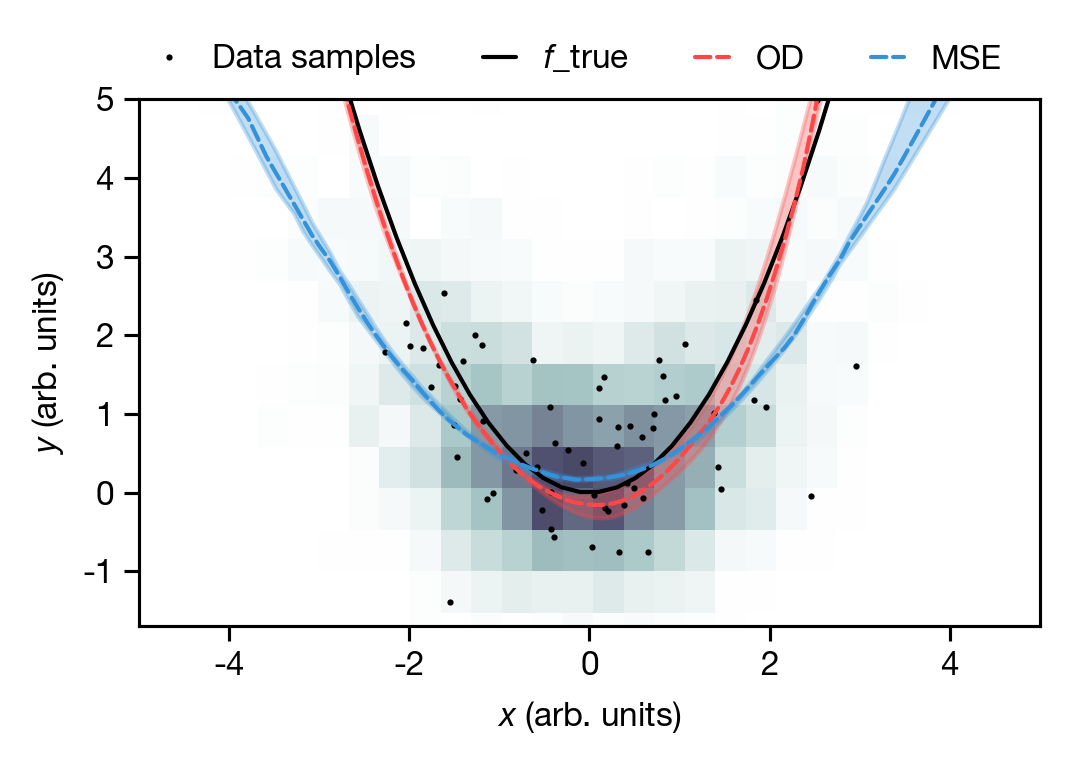

In [84]:
from plot_style.style_prab import figsize

f = lambda x : np.sqrt(0.5)*x**2 
fig_w = figsize['inch']['column_width']

fig,ax = plt.subplots(1,1,figsize=(fig_w,fig_w*0.7))
x_lin = np.linspace(-5,5)

ax.hist2d(trainset.x.detach().flatten().numpy(),trainset.y.detach().flatten().numpy(),cmap='bone_r',bins=25,vmax=200)
ax.plot(testset.x.detach().flatten().numpy()[::8],testset.y.detach().flatten().numpy()[::8],'.',color='k',ms=3.,mew=0,label='Data samples')

ax.plot(x_lin,f(x_lin),color='k',label=r'$f$_true',lw=1.)
ax.fill_between(x.flatten(),q_OD_low.flatten(),q_OD_high.flatten(),color=colors_preset[0],lw=1.,alpha=0.3)
ax.fill_between(x.flatten(),q_MSE_low.flatten(),q_MSE_high.flatten(),color=colors_preset[3],lw=1.,alpha=0.3)
ax.plot(x,mean_OD,ls='--',color=colors_preset[0],label='OD',lw=1.)
ax.plot(x,mean_MSE,ls = '--',color=colors_preset[3],label='MSE',lw=1.)


k_ols = np.polyfit(trainset.x.flatten(),trainset.y.flatten(),2)


#ax.plot(x_lin,k_ols[0]*x_lin**2+k_ols[1]*x_lin+k_ols[2],'-o',color='gray',label='OLS',lw=0.3,ms=1.)
#ax.plot(x_lin,k_odr[0]*x_lin**2+k_odr[1]*x_lin+k_odr[2],'-s',color='gray',label='ODR',lw=0.3,ms=1)


ax.set_xlim(-5,5)
ax.set_ylim(-1.7,5.)
ax.set_xlabel(r'$x$ (arb. units)')
ax.set_ylabel('$y$ (arb. units)')

ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
          #mode="expand", 
          borderaxespad=0, 
          ncol=4,
          frameon=False,
          handlelength=1)

plt.savefig('figures/toy_problem.png')